# Phase Reconstruction 4
This file aims to create a working prototype for windowed averages to fix false 2pi jumps

## Initialisation and Choice of Trace

In [2]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   └ This Jupyter notebook(.ipynb)

# Initialization: Directory appending for my system. Vary the directories as necessary.
import sys
import os.path as path
# Add the FYPLibrary folder in the parent level of this folder.
if path.join(path.dirname(path.abspath('')), 'FYPLibrary') not in sys.path:
    sys.path.append(path.join(path.dirname(path.abspath('')), 'FYPLibrary'))

# from pprint import pprint
# pprint(sys.path)

# within this jupyter notebook
from os import listdir
from file_reading import *
import matplotlib.pyplot as plt
from math import pi as pi
from scipy import signal
import numpy as np
from IQ_demod import *

In [3]:
# Yield all files in batch folder
folderpath = path.join(path.abspath(''),'traces')
for i, f in enumerate(files:= listdir(path= folderpath)):
    print(f"{i:>3}: {f}")


  0: C1-004Hz-020.2mVpp-80.125000MHz-OneAmp00002.txt
  1: C1-004Hz-020.4mVpp-80.125000MHz-OneAmp00001.txt
  2: C1-122Hz-020mVpp-80.125000MHz-OneAmp00001.txt
  3: C2-000Hz-000mVpp-80.1250448MHz00004.txt
  4: C2-000Hz-000mVpp-80.1250448MHz00005.txt
  5: C2-ball-drop-00002.txt


In [4]:
# my_input = int(input("Please specify which file you would like to generate a periodogram of: "))
my_input = 5
NAME = files[my_input]
TXT_FILE_PATH = file_str_to_path(NAME, dir=folderpath)
print(f"{TXT_FILE_PATH = }")
# _, mirror_f, mVpp, delta_corr = numerical_variables_from_name(NAME)
# print(f"{mirror_f = }, {mVpp = }, {delta_corr = }")

TXT_FILE_PATH = 'd:\\NUS\\Semester 7\\PC4199 Honours Project\\20211215 phase reconstruction experimental\\traces\\C2-ball-drop-00002.txt'


N = 4
[Notice] Ignore the following mixed types warning.


C:\Users\Thormund\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


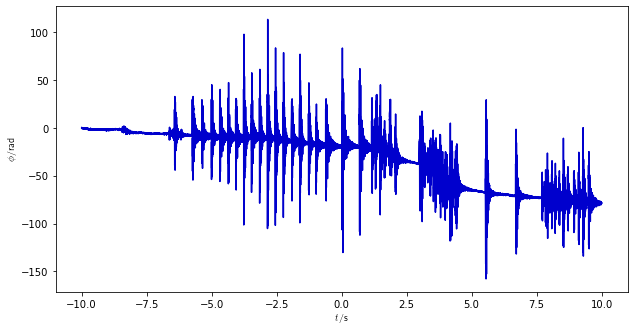

In [5]:
# most setups
SIGNAL_F = 80.125e6*2 #Hz 
SAMPLING_F = 1.0e6 #Hz

# ball drop #
if my_input == 5:
    SIGNAL_F = 80.0125e6*2
    SAMPLING_F = 100e3
N, _ = freq_ratio(signal= SIGNAL_F, sample= SAMPLING_F)
ph_ad = phase_advance(f_signal= SIGNAL_F, f_sample= SAMPLING_F)

print(f"{N = }")
meta, trace = parse_and_read_oscilliscope_txt(TXT_FILE_PATH)
signal = signal_from_trace(np.asarray(trace))
# delta_accumulation is preferred
# phases = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction= True)
# phases = phase_reconstruction(phases, 4.3)
phases = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction= False)
phases = phase_reconstruction_2(phases, ph_ad)
t_axis = timeaxis_from_trace(trace)[N:]
# t_axis = np.arange(start= 0, 
#     stop= (int(meta["Record Length"][0])-N) * meta['Sample Interval'][0],
#     step= meta['Sample Interval'][0])

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis, phases, color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)


In [6]:
# note that signal in this interval is
print(f"{len(signal) = }")
print(f"{len(phases) = }")
# signal[zoom_in_start+N:zoom_in_end+N]

len(signal) = 2000000
len(phases) = 1999996


Text(0.5, 0, '$t$/s')

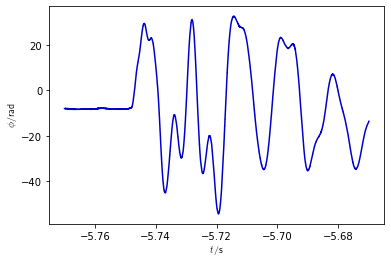

In [7]:
zoom_in_start2 = 423000
zoom_in_end2 = zoom_in_start2 + 10000

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis[zoom_in_start2:zoom_in_end2], phases[zoom_in_start2:zoom_in_end2], color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)

## Creation of windowed average prototype

In [8]:
from math import copysign
sign = lambda x: 0 if x == 0 else int(copysign(1,x))

In [9]:
def rmsc(arr):
    # returns rms(arr - arr.mean)
    arr = np.asarray(arr)
    t = arr - arr.mean()
    return np.sqrt(np.mean(np.square(t)))

In [10]:
class fix2pi():
    def __init__(self):
        self.stream = []
        self.shift = 0
        self.shift_counter = 0
        self.prevjump = 0
        self.buflen = 0
        self.cutoff = 64
        self.rollen = 8
        self.rolavg = []
        self.counter = 0
        
        self.tol = 1 # 2 * rms(noise) + a bit more
        
    def process(self,data):
        # main loop that takes in 
        data += self.shift*2*pi
        self.stream.append(data)
        self.counter +=1

        # when the buffer is not filled, populate and terminate fn call
        if self.buflen != self.cutoff:
            self.buflen +=1
            if self.buflen == self.rollen:
                self.rolavg.append(sum(self.stream)/self.rollen)
            elif self.buflen >= self.rollen:
                self.rolavg.append((self.stream[-1]-self.stream[-1-self.rollen])/self.rollen+self.rolavg[-1])
            return None
        # addition of 2 numbers to get rolling average
        self.rolavg.append((self.stream[-1]-self.stream[-1-self.rollen])/self.rollen+self.rolavg[-1])
        
        # check if jump is centered around 2 pi
        jump = self.rolavg[-1] - self.rolavg.pop(0)
        jump_sub = abs(jump) - 2*np.pi
        if abs(jump_sub) < self.tol: # make sure the signs are the same
            if sign(jump) == self.prevjump:
                self.shift_counter += 1
            else:
                self.shift_counter = max(0, self.shift_counter-1)
        else:
            self.shift_counter = max(0, self.shift_counter-1)
        self.prevjump = sign(jump)

        if self.shift_counter == 0 and self.counter % self.buflen == 0: # condition need to change
            if 0.5*self.tol < rmsc(self.stream) < 1.5*self.tol:
                self.tol = 0.8*self.tol + 0.2*rmsc(self.stream)
            # print(f"{self.counter = :>10}, {self.tol = :>7.4f}")
            if self.tol > np.pi:
                print("abvc")
                self.tol = 0
                self.counter -= self.rollen

        # print(f"{jump_sub = }, {self.prevjump = }")
        if self.shift_counter >= self.cutoff - self.rollen -0:
            print(f"jump detected at {self.counter:>10}")
            self.shift_counter = 0
            # implement shift
            self.shift -= self.prevjump
            # change rolling average
            jump_arg = np.argmax([abs(self.stream[i]-self.stream[i-1]) for i in range(1, self.buflen)]) + 1
            for i in range(jump_arg, self.buflen+1): self.stream[i] -= self.prevjump * 2 * pi
            for i in range(max(0,jump_arg-self.rollen),min(jump_arg,self.cutoff-self.rollen+1)): self.rolavg[i] -= self.prevjump*(i-jump_arg)*2*pi/self.rollen
            for i in range(jump_arg,self.cutoff-self.rollen+1): self.rolavg[i] -= self.prevjump*2*pi
            # print(self.prevjump)
        return self.stream.pop(0)
        # self.stream.pop(0)
        # return jump

    def get_buffer(self):
        return self.stream


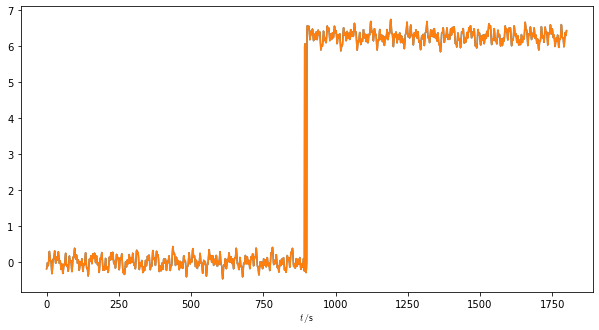

In [11]:
time = np.arange(-9,9,step=0.01)
t = np.sin(100*time)/10+2*np.pi*np.heaviside(time,0)+0.1*sum(np.sin(k*time) for k in [9.2, 20.2, 35.1,45.8])-2*np.pi*np.heaviside(time+0.05,0)+2*np.pi*np.heaviside(time+0.08,0)
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(t)

testclass = fix2pi()
y=[testclass.process(i) for i in t][64:]
y.extend(testclass.get_buffer())
plt.plot(y)
ax.set_xlabel(r'$t$/s', useTex = True)
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)

jump detected at    1151378


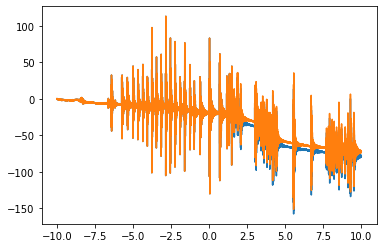

In [12]:
plt.plot(t_axis, phases)
testclass2 = fix2pi()
y=[testclass2.process(p) for p in phases][64:]
y.extend(testclass2.get_buffer())
plt.plot(t_axis, y)
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)

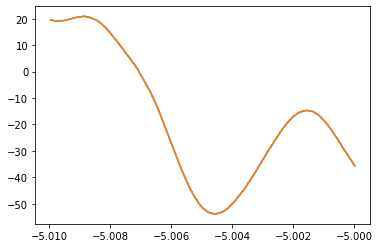

In [21]:
zoom_in_start = 499000
zoom_in_end = zoom_in_start + 1000
testclass2 = fix2pi()
plt.plot(t_axis[zoom_in_start:zoom_in_end], phases[zoom_in_start:zoom_in_end])
plt.plot(t_axis[zoom_in_start:zoom_in_end], y[zoom_in_start:zoom_in_end])
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)